# ***BERT Knows Both Ways: Catching Lies from Every Angle***
## Overview of Model Development Steps:

- Installed and imported necessary libraries and tools.

- Loaded and cleaned dataset, then labeled data as True or False.

- Applied text augmentation to enrich training data.

- Tokenized text data using BERT tokenizer.

- Built and trained BERT sequence classification model with class weighting.



---



In [ ]:
# Install the required packages and libraries
!pip install transformers torch pandas numpy matplotlib seaborn scikit-learn
!pip install nlpaug

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw

In [ ]:
# Check device
print("GPU is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

GPU is available: True
Device being used: cuda


In [ ]:
# Load and preprocess data
df = pd.read_csv('politifact.csv')
df['statement'] = df['statement'].str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

# Keep only binary classes: True/Mostly True vs. the rest
df = df[df['veracity'].isin(['True', 'Mostly True', 'Pants on Fire!', 'False', 'Mostly False'])]
df['binary_label'] = df['veracity'].apply(lambda label: 1 if label in ['True', 'Mostly True'] else 0)

# Map veracity to binary label
df['label'] = df['veracity'].apply(lambda label: 1 if label in ['True', 'Mostly True'] else 0)

# Display label distribution
print("Label distribution (binary):")
print(df['label'].value_counts())



Label distribution (binary):
label
0    6335
1    4853
Name: count, dtype: int64
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
. Proceeding without augmentation.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Data augmentation (optional)
try:
    aug_synonym = naw.SynonymAug(aug_p=0.5)
    aug_random = naw.RandomWordAug(action="swap", aug_p=0.3)
    train_df['statement_synonym'] = train_df['statement'].apply(lambda x: aug_synonym.augment(x)[0])
    train_df['statement_random'] = train_df['statement'].apply(lambda x: aug_random.augment(x)[0])
    train_df = pd.concat([
        train_df[['statement', 'label']],
        train_df[['statement_synonym', 'label']].rename(columns={'statement_synonym': 'statement'}),
        train_df[['statement_random', 'label']].rename(columns={'statement_random': 'statement'})
    ])
    print("Data augmentation applied (synonym + random word swap).")
except Exception as e:
    print(f"Warning: Augmentation failed: {e}. Proceeding without augmentation.")

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
# Dataset class
class TruthDetectionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['statement'])
        label = int(self.data.iloc[index]['binary_label'])  # CHANGED to binary_label

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Hyperparameters
MAX_LEN = 128
LEARNING_RATE = 1e-5
BATCH_SIZE = 8
DROPOUT_RATE = 0.6
EPOCHS = 5
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.3
PATIENCE = 4

In [ ]:
print("Unique labels:", df['veracity'].unique())
print("\nLabel counts:")
print(df['veracity'].value_counts())

Unique labels: ['Pants on Fire!' 'Mostly True' 'False' 'True' 'Mostly False']

Label counts:
veracity
Mostly True       2695
False             2641
Mostly False      2335
True              2158
Pants on Fire!    1359
Name: count, dtype: int64


In [ ]:
# Create datasets and loaders
train_dataset = TruthDetectionDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TruthDetectionDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TruthDetectionDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# Initialize BERT model for binary classification
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # BINARY classification
    hidden_dropout_prob=DROPOUT_RATE,
    attention_probs_dropout_prob=DROPOUT_RATE
)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=config
).to(device)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['binary_label']), y=df['binary_label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function for binary classification
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_RATIO * total_steps),
    num_training_steps=total_steps
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            probs = torch.softmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return {
        'accuracy': correct_predictions.double() / len(data_loader.dataset),
        'loss': np.mean(losses),
        'preds': np.array(all_preds),
        'labels': np.array(all_labels),
        'probs': np.array(all_probs)
    }


In [ ]:
best_val_loss = float('inf')
best_accuracy = 0
patience_counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_results = eval_model(model, val_loader, loss_fn, device)
    val_acc, val_loss = val_results['accuracy'], val_results['loss']
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train loss: {train_loss:.4f} | accuracy: {train_acc:.4f}')
    print(f'Val loss: {val_loss:.4f} | accuracy: {val_acc:.4f}\n')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break

# Load best model
model.load_state_dict(torch.load('best_model_state.bin'))

# Evaluate on test set
test_results = eval_model(model, test_loader, loss_fn, device)


Epoch 1/5
----------
Train loss: 0.7251 | accuracy: 0.5114
Val loss: 0.7049 | accuracy: 0.5602

Epoch 2/5
----------
Train loss: 0.7100 | accuracy: 0.5270
Val loss: 0.7022 | accuracy: 0.5650

Epoch 3/5
----------
Train loss: 0.7055 | accuracy: 0.5411
Val loss: 0.6950 | accuracy: 0.5584

Epoch 4/5
----------
Train loss: 0.6995 | accuracy: 0.5385
Val loss: 0.6947 | accuracy: 0.5614

Epoch 5/5
----------
Train loss: 0.6997 | accuracy: 0.5404
Val loss: 0.6945 | accuracy: 0.5662




Test Set Metrics:
Accuracy: 0.5527
Precision: 0.3231
Recall: 0.0288
F1 Score: 0.0530
ROC AUC: 0.5196


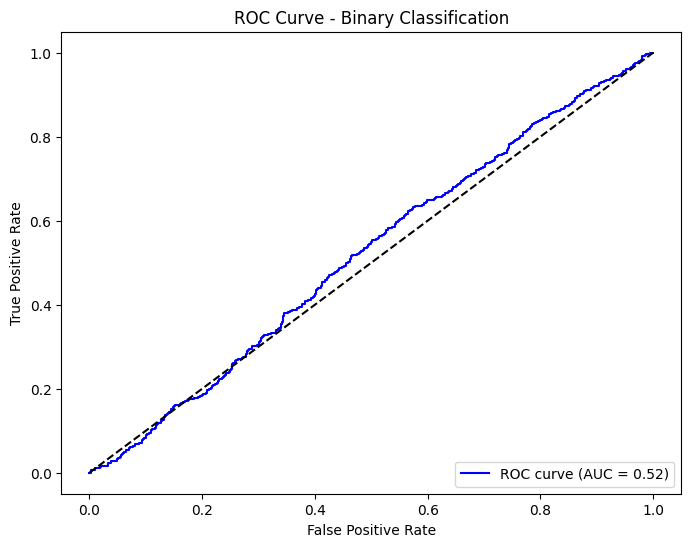


Confusion Matrix:


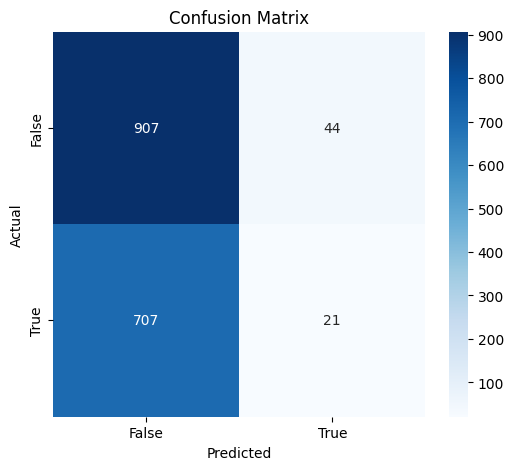


Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.95      0.71       951
        True       0.32      0.03      0.05       728

    accuracy                           0.55      1679
   macro avg       0.44      0.49      0.38      1679
weighted avg       0.46      0.55      0.42      1679



In [ ]:
# Metrics function
def calculate_metrics(labels, preds, probs):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

    # ROC curve for class 1
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    metrics['roc_auc'] = roc_auc

    return metrics, fpr, tpr

# Calculate metrics
binary_metrics, fpr, tpr = calculate_metrics(
    test_results['labels'],
    test_results['preds'],
    test_results['probs']
)

# Print metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
print(f"Precision: {binary_metrics['precision']:.4f}")
print(f"Recall: {binary_metrics['recall']:.4f}")
print(f"F1 Score: {binary_metrics['f1']:.4f}")
print(f"ROC AUC: {binary_metrics['roc_auc']:.4f}")



In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {binary_metrics["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()




In [ ]:
# Confusion Matrix
def plot_confusion_matrix(labels, preds):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

print("\nConfusion Matrix:")
plot_confusion_matrix(test_results['labels'], test_results['preds'])

# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_results['labels'], test_results['preds'], target_names=['False', 'True']))